# 1. Libraries 

In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from pyod.models.iforest import IForest
from pyod.models.pca import PCA

from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score

import tensorflow as tf

import seaborn as sns
sns.set_style('white')

import warnings
warnings.filterwarnings(action='ignore')

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [373]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print(tf.config.list_physical_devices('GPU'))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3413645083828668655
xla_global_id: -1
]
[]


In [3]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = '0' # 여러개 사용시 '0,1,2' 식으로 하나의 문자열에 입력
gpus = tf.config.experimental.list_physical_devices('GPU') # 호스트 러나임에 표시되는 GPU 장치 목록 반환

if gpus: # 반환된 GPU 장치 목록이 있다면
    try: # 해당 장치에 대한 메모리 증가 활성화 여부 설정
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e: # try문 실패시에 에러문구 출력
        print(e)

In [4]:
path = "./Dataset/"

dataT = pd.read_csv(path+"train_T.csv")  
dataO = pd.read_csv(path+"train_O.csv")  

# original data -> data
data = pd.concat([dataT, dataO]).reset_index(drop=True)
data

,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
0,1,0.531957,T100304,T_31,2.0,95.0,0.0,45.0,10.0,0.0,...,0.000008,0.000003,0.191408,0.000008,0.001210,0.000021,0.000003,0.000002,0.189,0.000006
1,1,0.531105,T100306,T_31,2.0,96.0,0.0,45.0,10.0,0.0,...,0.000008,0.000003,0.188993,0.000032,0.000644,0.000041,0.000002,0.000003,0.185,0.000029
2,1,0.532292,T100306,T_31,2.0,95.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0.528141,T100306,T_31,2.0,87.0,0.0,45.0,10.0,0.0,...,0.000007,0.000003,0.189424,0.000034,0.000678,0.000043,0.000004,0.000003,0.188,0.000031
4,1,0.532289,T100306,T_31,2.0,95.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,1,0.529740,T100304,O_31,154.0,97.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
834,1,0.532343,T100306,O_31,146.0,94.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
835,1,0.530533,T100304,O_31,4.0,98.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
836,2,0.535205,T100306,O_31,6.0,89.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 2. Preprocessing

1. 같은 값으로만 채워진 column 삭제 (nunique(dropna=False) <= 1) 
2. 모든 행이 같은 값을 가지는 두 개 이상의 중복된 column 삭제 
3. 결측치 처리 (KNN Imputetor, fillna(0))
4. 정규화 (Robust, MinMax, Standard)
5. 카테고리 변수 수치화 (LINE, PRODUCT_CODE) LabelEncoder

In [461]:
# 1. Handling missing values  
# Preprocessed data -> processed_data
processed_data = data.copy()
processed_data = processed_data.fillna(0)
processed_data

,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
0,1,0.531957,T100304,T_31,2.0,95.0,0.0,45.0,10.0,0.0,...,0.000008,0.000003,0.191408,0.000008,0.001210,0.000021,0.000003,0.000002,0.189,0.000006
1,1,0.531105,T100306,T_31,2.0,96.0,0.0,45.0,10.0,0.0,...,0.000008,0.000003,0.188993,0.000032,0.000644,0.000041,0.000002,0.000003,0.185,0.000029
2,1,0.532292,T100306,T_31,2.0,95.0,0.0,45.0,10.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
3,1,0.528141,T100306,T_31,2.0,87.0,0.0,45.0,10.0,0.0,...,0.000007,0.000003,0.189424,0.000034,0.000678,0.000043,0.000004,0.000003,0.188,0.000031
4,1,0.532289,T100306,T_31,2.0,95.0,0.0,45.0,10.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,1,0.529740,T100304,O_31,154.0,97.0,0.0,45.0,11.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
834,1,0.532343,T100306,O_31,146.0,94.0,0.0,45.0,10.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
835,1,0.530533,T100304,O_31,4.0,98.0,0.0,45.0,11.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
836,2,0.535205,T100306,O_31,6.0,89.0,0.0,45.0,10.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000


In [462]:
# 2. 같은 값으로만 채워진 column 삭제 (nunique(dropna=False) <= 1)
# Get the counts of unique values per column
value_counts = processed_data.iloc[:,4:].apply(lambda x: x.nunique(dropna=False))

# Filter columns with only one unique value
unique_columns = value_counts[value_counts >= 2].index
duplicated_columns = value_counts[value_counts <= 1].index

processed_data = processed_data.drop(duplicated_columns, axis=1)
processed_data

,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_1,X_2,X_4,X_5,X_7,X_8,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
0,1,0.531957,T100304,T_31,2.0,95.0,45.0,10.0,45.0,10.0,...,0.000008,0.000003,0.191408,0.000008,0.001210,0.000021,0.000003,0.000002,0.189,0.000006
1,1,0.531105,T100306,T_31,2.0,96.0,45.0,10.0,53.0,10.0,...,0.000008,0.000003,0.188993,0.000032,0.000644,0.000041,0.000002,0.000003,0.185,0.000029
2,1,0.532292,T100306,T_31,2.0,95.0,45.0,10.0,60.0,10.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
3,1,0.528141,T100306,T_31,2.0,87.0,45.0,10.0,53.0,10.0,...,0.000007,0.000003,0.189424,0.000034,0.000678,0.000043,0.000004,0.000003,0.188,0.000031
4,1,0.532289,T100306,T_31,2.0,95.0,45.0,10.0,51.0,10.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,1,0.529740,T100304,O_31,154.0,97.0,45.0,11.0,45.0,10.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
834,1,0.532343,T100306,O_31,146.0,94.0,45.0,10.0,67.0,11.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
835,1,0.530533,T100304,O_31,4.0,98.0,45.0,11.0,45.0,10.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
836,2,0.535205,T100306,O_31,6.0,89.0,45.0,10.0,51.0,10.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000


In [463]:
# 3. 모든 행이 같은 값을 가지는 두 개 이상의 중복된 column 삭제
df = processed_data.iloc[:,4:].T.drop_duplicates(keep='first').T
processed_data = pd.concat([processed_data.iloc[:,:4], df], axis=1)
processed_data

,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_1,X_2,X_4,X_5,X_7,X_8,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
0,1,0.531957,T100304,T_31,2.0,95.0,45.0,10.0,45.0,10.0,...,0.000008,0.000003,0.191408,0.000008,0.001210,0.000021,0.000003,0.000002,0.189,0.000006
1,1,0.531105,T100306,T_31,2.0,96.0,45.0,10.0,53.0,10.0,...,0.000008,0.000003,0.188993,0.000032,0.000644,0.000041,0.000002,0.000003,0.185,0.000029
2,1,0.532292,T100306,T_31,2.0,95.0,45.0,10.0,60.0,10.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
3,1,0.528141,T100306,T_31,2.0,87.0,45.0,10.0,53.0,10.0,...,0.000007,0.000003,0.189424,0.000034,0.000678,0.000043,0.000004,0.000003,0.188,0.000031
4,1,0.532289,T100306,T_31,2.0,95.0,45.0,10.0,51.0,10.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,1,0.529740,T100304,O_31,154.0,97.0,45.0,11.0,45.0,10.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
834,1,0.532343,T100306,O_31,146.0,94.0,45.0,10.0,67.0,11.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
835,1,0.530533,T100304,O_31,4.0,98.0,45.0,11.0,45.0,10.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
836,2,0.535205,T100306,O_31,6.0,89.0,45.0,10.0,51.0,10.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000


In [464]:
# 4. Regularization 
rs = RobustScaler()
ss = StandardScaler()

processed_data.iloc[:, 4:] = rs.fit_transform(processed_data.iloc[:, 4:])
processed_data

,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_1,X_2,X_4,X_5,X_7,X_8,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
0,1,0.531957,T100304,T_31,0.0,0.0,0.0,0.0,-0.833333,0.0,...,0.000008,0.000003,0.191408,0.000008,0.001210,0.000021,0.000003,0.000002,0.189,0.000006
1,1,0.531105,T100306,T_31,0.0,0.2,0.0,0.0,0.500000,0.0,...,0.000008,0.000003,0.188993,0.000032,0.000644,0.000041,0.000002,0.000003,0.185,0.000029
2,1,0.532292,T100306,T_31,0.0,0.0,0.0,0.0,1.666667,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
3,1,0.528141,T100306,T_31,0.0,-1.6,0.0,0.0,0.500000,0.0,...,0.000007,0.000003,0.189424,0.000034,0.000678,0.000043,0.000004,0.000003,0.188,0.000031
4,1,0.532289,T100306,T_31,0.0,0.0,0.0,0.0,0.166667,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,1,0.529740,T100304,O_31,152.0,0.4,0.0,1.0,-0.833333,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
834,1,0.532343,T100306,O_31,144.0,-0.2,0.0,0.0,2.833333,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
835,1,0.530533,T100304,O_31,2.0,0.6,0.0,1.0,-0.833333,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
836,2,0.535205,T100306,O_31,4.0,-1.2,0.0,0.0,0.166667,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000


In [465]:
# 5. Label Encoding 
cat_cols = ['PRODUCT_CODE', 'LINE']

for col in cat_cols:
    le = LabelEncoder()
    processed_data[col] = le.fit_transform(processed_data[col])
    print(le.classes_)

processed_data.head()

['O_31' 'T_31']
['T100304' 'T100306']


,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_1,X_2,X_4,X_5,X_7,X_8,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
0,1,0.531957,0,1,0.0,0.0,0.0,0.0,-0.833333,0.0,...,0.000008,0.000003,0.191408,0.000008,0.001210,0.000021,0.000003,0.000002,0.189,0.000006
1,1,0.531105,1,1,0.0,0.2,0.0,0.0,0.500000,0.0,...,0.000008,0.000003,0.188993,0.000032,0.000644,0.000041,0.000002,0.000003,0.185,0.000029
2,1,0.532292,1,1,0.0,0.0,0.0,0.0,1.666667,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
3,1,0.528141,1,1,0.0,-1.6,0.0,0.0,0.500000,0.0,...,0.000007,0.000003,0.189424,0.000034,0.000678,0.000043,0.000004,0.000003,0.188,0.000031
4,1,0.532289,1,1,0.0,0.0,0.0,0.0,0.166667,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000


In [447]:
# Optional. 차원 축소
from sklearn.decomposition import PCA 

nonX_data = processed_data.iloc[:, :4]
X_data = processed_data.iloc[:, 4:]

pca = PCA(n_components=2)
pca_data = pca.fit_transform(X_data) 
pca_df = pd.DataFrame(pca_data) # , columns=['X1', 'X2', 'X3']

processed_data = pd.concat([nonX_data, pca_df], axis=1)
processed_data

,Y_Class,Y_Quality,LINE,PRODUCT_CODE,0,1
0,1,0.531957,0,1,16101.086813,-974.254424
1,1,0.531105,1,1,46349.903278,-1702.853292
2,1,0.532292,1,1,-5094.754043,90.722540
3,1,0.528141,1,1,-3136.625768,-382.507494
4,1,0.532289,1,1,-5094.754110,90.722835
...,...,...,...,...,...,...
833,1,0.529740,0,0,-5094.760959,90.719835
834,1,0.532343,1,0,-5094.762151,90.722869
835,1,0.530533,0,0,-5094.753880,90.723373
836,2,0.535205,1,0,-5094.754097,90.722048


In [388]:
# # Optional. 차원 축소 TSNE
# from sklearn.manifold import TSNE

# nonX_data = processed_data.iloc[:, :4]
# X_data = processed_data.iloc[:, 4:]

# tsne_data = TSNE(n_components=2).fit_transform(X_data)
# tsne_df = pd.DataFrame(tsne_data)

# processed_data = pd.concat([nonX_data, tsne_df], axis=1)
# processed_data

,Y_Class,Y_Quality,LINE,PRODUCT_CODE,0,1
0,1,0.531957,0,1,35.515476,9.955524
1,1,0.531105,1,1,44.606117,-2.690729
2,1,0.532292,1,1,-12.543271,3.508772
3,1,0.528141,1,1,21.295027,8.277346
4,1,0.532289,1,1,-11.813218,2.911385
...,...,...,...,...,...,...
833,1,0.529740,0,0,-35.270580,-2.117869
834,1,0.532343,1,0,-35.266968,-2.124911
835,1,0.530533,0,0,0.447383,31.928679
836,2,0.535205,1,0,-7.322104,9.309781


In [430]:
# # Optional. 차원 축소 uMAP
# import umap  

# nonX_data = processed_data.iloc[:, :4]
# X_data = processed_data.iloc[:, 4:]

# manifold = umap.UMAP().fit(X_data, nonX_data['Y_Class'])
# umap_data = manifold.transform(X_data)
# umap_df = pd.DataFrame(umap_data, columns=['X1', 'X2'])

# processed_data = pd.concat([nonX_data, umap_df], axis=1)
# processed_data

# plotting for uMAP 
# import umap.plot  # pip install umap-learn[plot]
# umap.plot.points(manifold, labels=y, theme="fire");
# plt.scatter(processed_data.iloc[:, 4], processed_data.iloc[:, 5], c=processed_data.iloc[:, 0], s=0.5);

,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X1,X2
0,1,0.531957,0,1,-9.801586,13.755045
1,1,0.531105,1,1,-11.304943,9.790709
2,1,0.532292,1,1,-11.473473,26.626455
3,1,0.528141,1,1,-5.300025,16.529797
4,1,0.532289,1,1,-11.713386,26.700748
...,...,...,...,...,...,...
833,1,0.529740,0,0,8.479136,-13.534165
834,1,0.532343,1,0,8.377977,-14.000867
835,1,0.530533,0,0,6.687188,23.084654
836,2,0.535205,1,0,-10.087385,24.797380


In [471]:
from sklearn import metrics
from sklearn.cluster import DBSCAN

nonX_data = processed_data.iloc[:, :4]
X_data = processed_data.iloc[:, 4:]

db = DBSCAN(eps=0.001, min_samples=10).fit(X_data)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 0
Estimated number of noise points: 838


# 3. Data Split

In [448]:
# Divide processed_data to abnormal and normal 
normal_data = processed_data[processed_data['Y_Class']==1]
normal_data['Y_Class'] = normal_data['Y_Class'].replace({1: 0}) # normal -> 0

undershoot = processed_data[processed_data['Y_Class']==0]
overshoot = processed_data[processed_data['Y_Class']==2]
abnormal_data = pd.concat([undershoot, overshoot])
abnormal_data['Y_Class'] = abnormal_data['Y_Class'].replace({2: 1, 0: 1}) # abnormal -> 1 

print('Normal Data:', normal_data.shape, ', Abnormal Data:', abnormal_data.shape)

# Create test data (normal 202, abnormal 202 = 404)
test_normal = normal_data.sample(n = 202, random_state = 42)
test_data = pd.concat([test_normal, abnormal_data])

# Create train data based on normal data (636 - 202 = 434)
train_normal = normal_data.drop(test_normal.index)

print('Train Normal Data:', train_normal.shape, ', Test Mixed Data:', test_data.shape)

#Divide data to X  data and y data 
train_y = train_normal['Y_Class']
train_X = train_normal.drop(['Y_Class', 'LINE', 'PRODUCT_CODE', 'Y_Quality'], axis=1)
test_y = test_data['Y_Class']
test_X = test_data.drop(['Y_Class', 'LINE', 'PRODUCT_CODE', 'Y_Quality'], axis=1)

print('Train X:', train_X.shape, ', Train y:', train_y.shape)
print('Test X:', test_X.shape, ', Test y:', test_y.shape, ', Test y value_countes: ', test_y.value_counts())

# For Y_Quality Experiments 
# train_X = pd.DataFrame(train_X['Y_Quality'])
# test_X = pd.DataFrame(test_X['Y_Quality'])

Normal Data: (636, 6) , Abnormal Data: (202, 6)
Train Normal Data: (434, 6) , Test Mixed Data: (404, 6)
Train X: (434, 2) , Train y: (434,)
Test X: (404, 2) , Test y: (404,) , Test y value_countes:  0    202
1    202
Name: Y_Class, dtype: int64


# 4. Modeling 


In [436]:
from pycaret.anomaly import *
from time import time

In [449]:
# Setup Environment  
anomaly = setup(data = train_X,
                preprocess = False,
                use_gpu = True,
                session_id = SEED)

,Description,Value
0,Session id,42
1,Original data shape,"(434, 2)"
2,Transformed data shape,"(434, 2)"
3,Numeric features,2


In [116]:
models()

,Name,Reference
ID,,
abod,Angle-base Outlier Detection,pyod.models.abod.ABOD
cluster,Clustering-Based Local Outlier,pycaret.internal.patches.pyod.CBLOFForceToDouble
cof,Connectivity-Based Local Outlier,pyod.models.cof.COF
iforest,Isolation Forest,pyod.models.iforest.IForest
histogram,Histogram-based Outlier Detection,pyod.models.hbos.HBOS
knn,K-Nearest Neighbors Detector,pyod.models.knn.KNN
lof,Local Outlier Factor,pyod.models.lof.LOF
svm,One-class SVM detector,pyod.models.ocsvm.OCSVM
pca,Principal Component Analysis,pyod.models.pca.PCA


In [450]:
# IForest, KNN, SVM, PCA, LoF, total five models  
iforest = create_model('iforest')
knn = create_model('knn')
svm = create_model('svm')
pca = create_model('pca')
lof = create_model('lof')

total_models = [iforest, knn,  svm, pca, lof]

In [ ]:
for model in total_models:
    plot_model(model, plot='tsne')

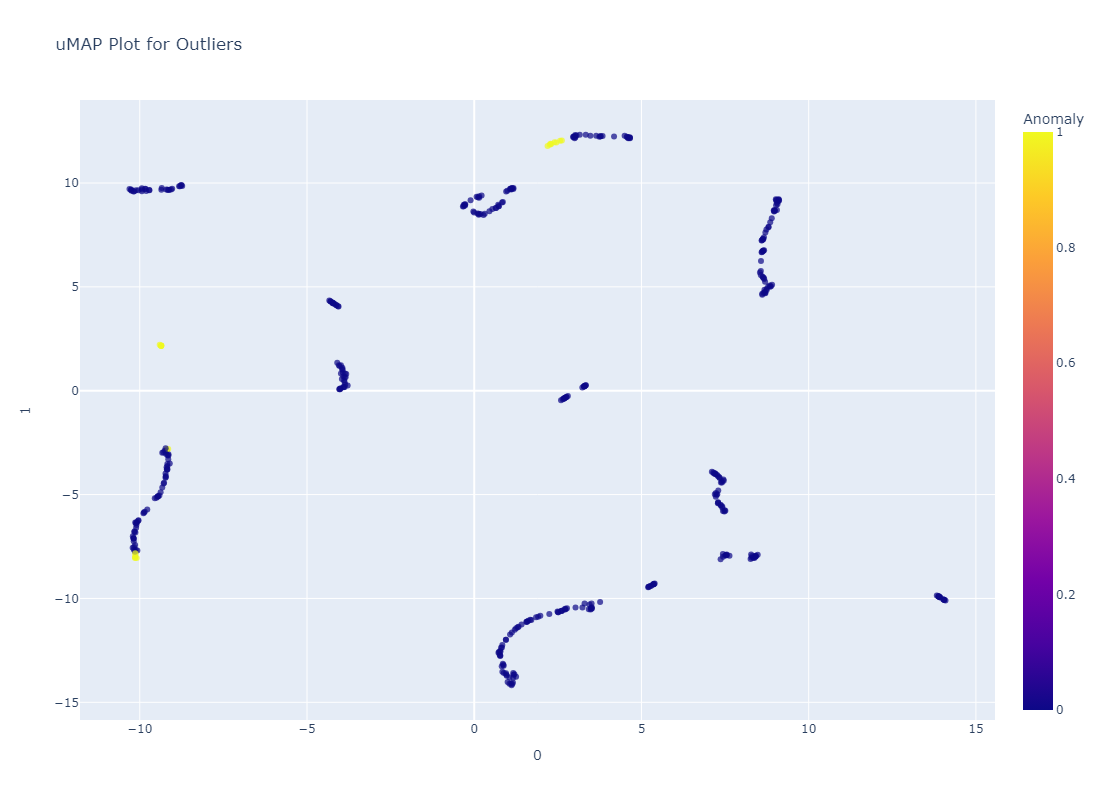

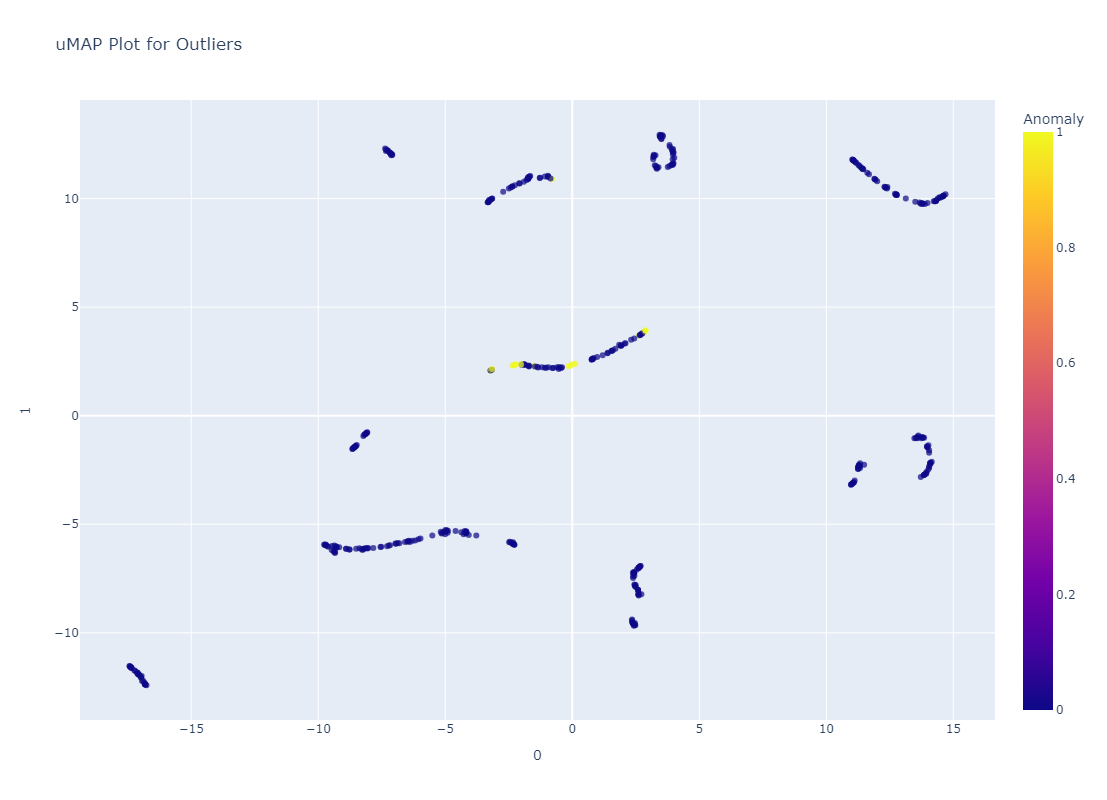

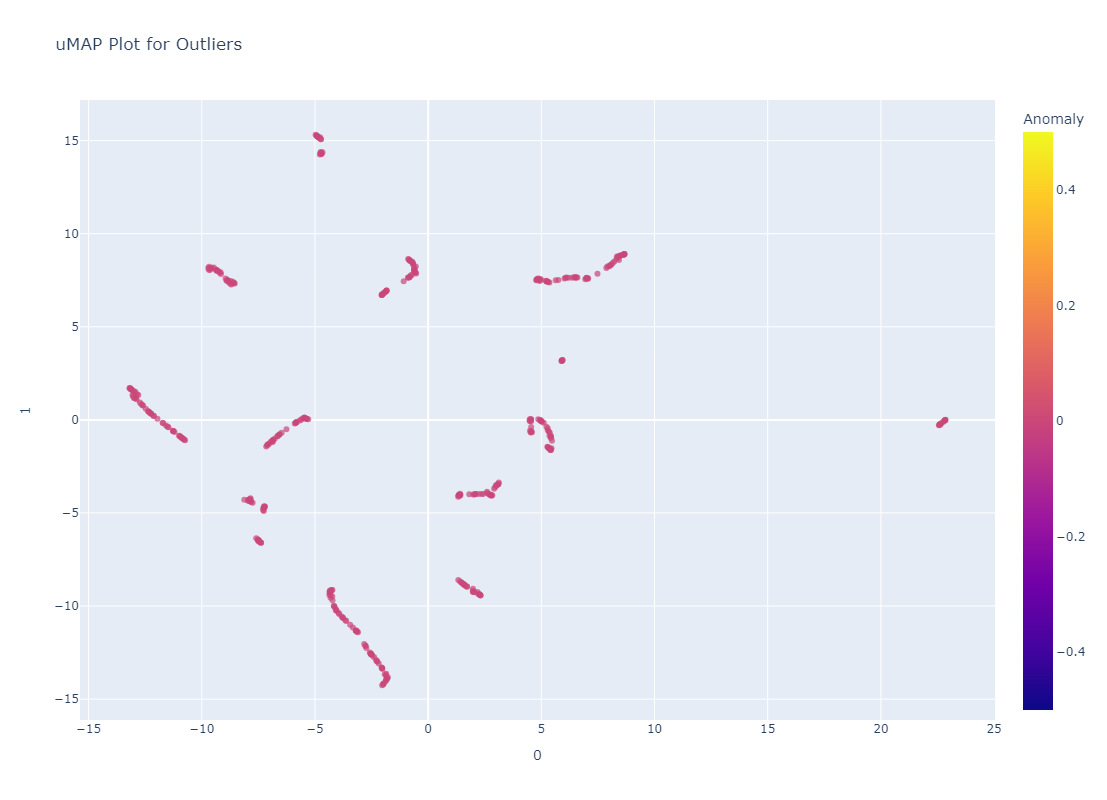

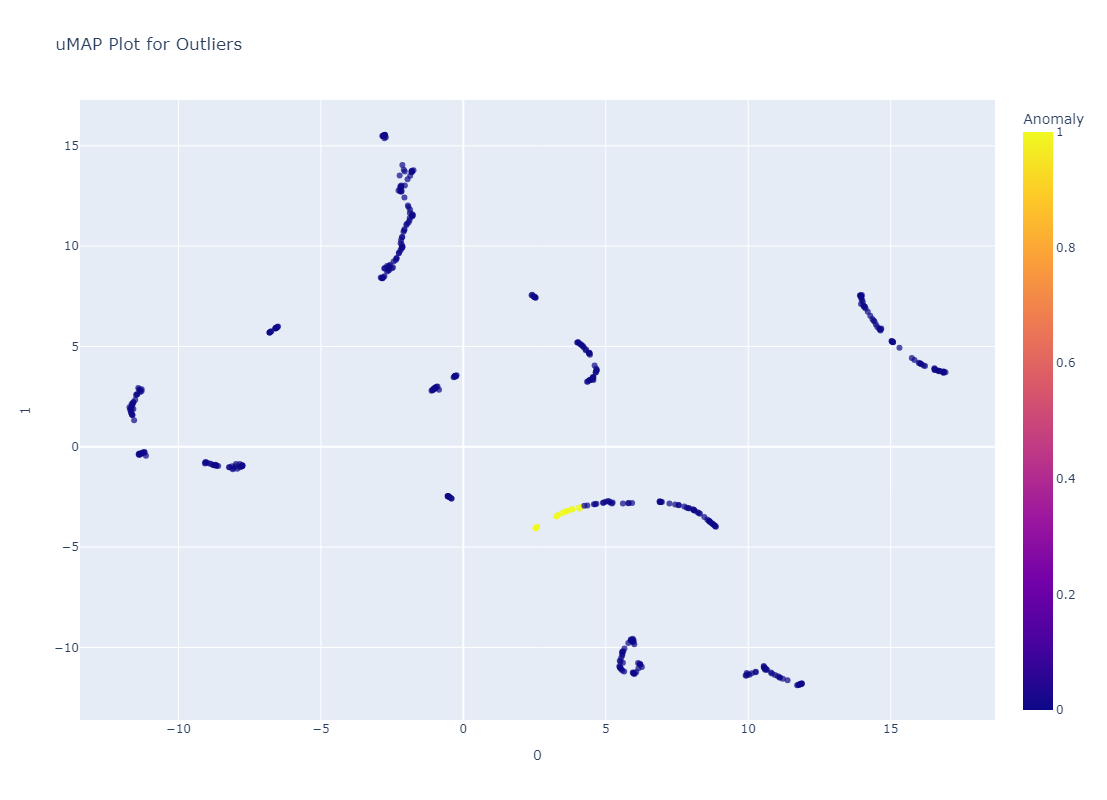

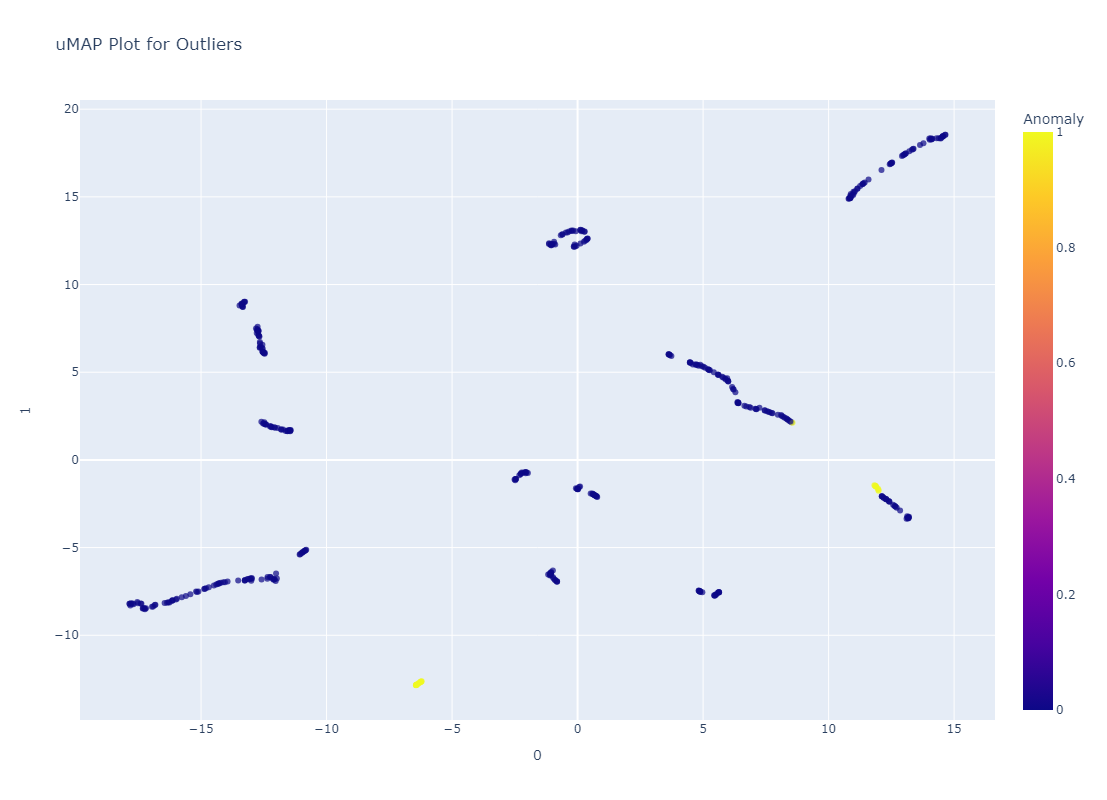

In [451]:
for model in total_models:
    plot_model(model, plot='umap')

In [452]:
results = []

for model in total_models:
    result = assign_model(model)
    results.append(result)
    result.head()

results[0].head()

,0,1,Anomaly,Anomaly_Score
0,16101.086914,-974.254395,0,-0.051451
1,46349.902344,-1702.853271,1,0.060580
3,-3136.625732,-382.507507,1,0.023461
4,-5094.753906,90.722832,0,-0.278155
5,31994.849609,-1316.621216,0,-0.034683


# 5. Prediction

In [453]:
test_X.columns = test_X.columns.astype('str')

In [454]:
predictions = []

for model in total_models:
    pred = predict_model(model, data=test_X)
    predictions.append(pred)

predictions[0].head()

,0,1,Anomaly,Anomaly_Score
341,-5094.754378,90.726848,0,-0.282846
831,-5094.753819,90.723327,0,-0.279463
96,-5094.754058,90.722685,0,-0.275383
451,-5099.296585,108.097653,0,-0.156392
176,-5094.754370,90.726328,0,-0.285076


In [455]:
def confusionMatrix(test_pred):
    con_mat = confusion_matrix(test_y, test_pred)
    sns.heatmap(pd.DataFrame(con_mat, columns = ['Predicted', 'Actual']),
            xticklabels=['Normal [0]', 'Abnormal [1]'], 
            yticklabels=['Normal [0]', 'Abnormal [1]'], 
            annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    print("accuracy: ", accuracy_score(test_y, test_pred))
    print("recall: ", round(recall_score(test_y, test_pred),3))
    print("precision: ", round(precision_score(test_y, test_pred),3))
    print("f1-score: ", round(f1_score(test_y, test_pred),3))

accuracy:  0.48514851485148514
recall:  0.05
precision:  0.385
f1-score:  0.088


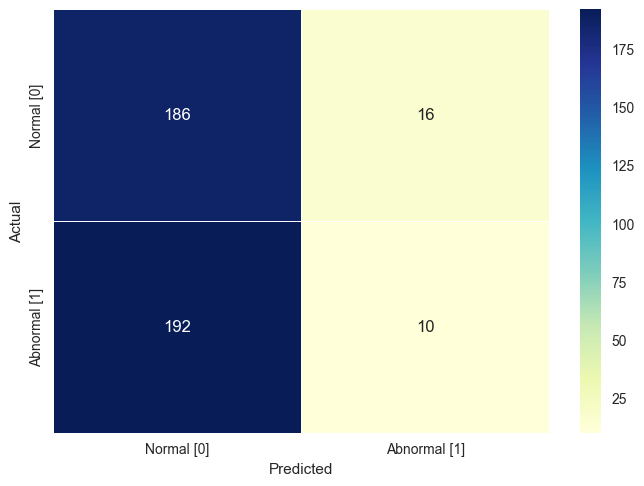

In [456]:
confusionMatrix(predictions[0]['Anomaly'])

accuracy:  0.47277227722772275
recall:  0.035
precision:  0.28
f1-score:  0.062


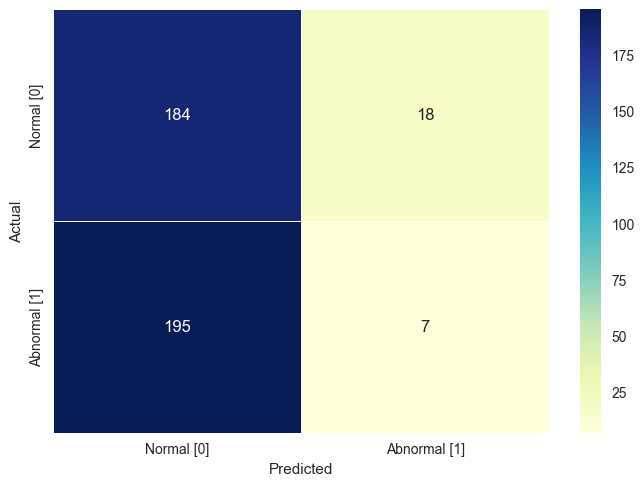

In [457]:
confusionMatrix(predictions[1]['Anomaly'])

accuracy:  0.48267326732673266
recall:  0.163
precision:  0.452
f1-score:  0.24


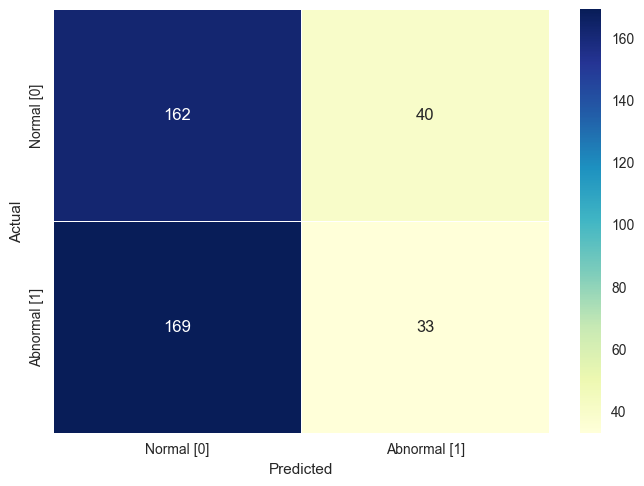

In [458]:
confusionMatrix(predictions[2]['Anomaly'])

accuracy:  0.4876237623762376
recall:  0.04
precision:  0.381
f1-score:  0.072


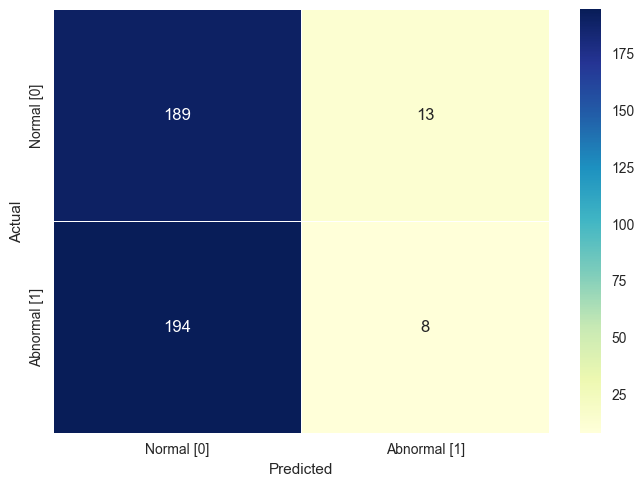

In [459]:
confusionMatrix(predictions[3]['Anomaly'])

accuracy:  0.49257425742574257
recall:  0.03
precision:  0.4
f1-score:  0.055


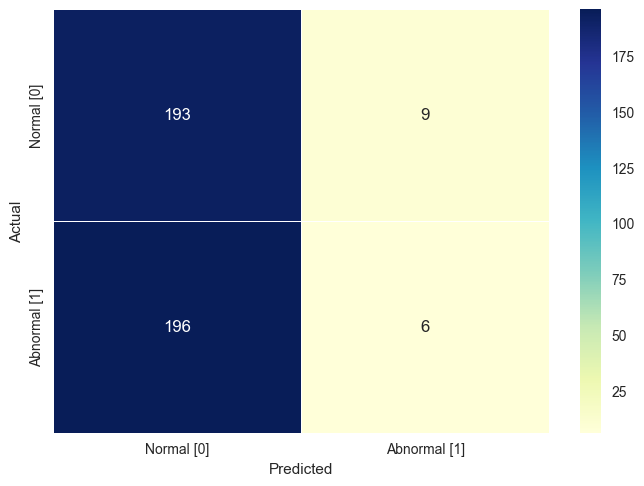

In [460]:
confusionMatrix(predictions[4]['Anomaly'])

In [372]:
plot_model(total_models[2], plot='tsne')

In [381]:
pred = predictions[2]
pred = pd.concat([pred, test_y], axis=1)

fig = px.scatter_3d(pred, x='0', y='1', z='2',
              color='Anomaly')
fig.show()